In [1]:
import numpy as np
import cedalion
import cedalion.nirs
import cedalion.imagereco.forward_model as fw
import cedalion.datasets
import os
import cedalion.xrutils as xrutils
import cedalion.plots
import xarray as xr
import cedalion.geometry.landmarks as cd_landmarks
import matplotlib.pyplot as plt
import cedalion.sim.synthetic_hrf as synHRF_ced
from cedalion import units
import cedalion.dataclasses as cdc
import pyvista as pv
import cedalion.models.glm as glm
from cedalion.imagereco.solver import pseudo_inverse_stacked
#pv.set_jupyter_backend('server') # this enables interactive plots
import cedalion.sigproc.quality as quality
from cedalion.sigproc.quality import repair_amp
import random
import pickle
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..', 'experiments'))
import configs

xr.set_options(display_expand_data=False);

import cedalion.datasets
import cedalion.plots
import cedalion.imagereco.forward_model as fw
from cedalion.imagereco.solver import pseudo_inverse_stacked

In [ ]:
data_path = configs.data_path_prefix
save = True
multiple = True
sp_scale = 1  # spatial scaling factor for HRF
head_model_name = 'icbm'
#head_model_name = 'colin'
num_activations = 18 # number of total runs in resting state dataset. we will probably use only 11 of those activations because we have 11 subjects. one hrf per subject.

## Loading and preprocessing the dataset

This notebook uses a HD whole head resting state dataset.

In [3]:
rec = cedalion.datasets.get_nn22_resting_state()

geo3d = rec.geo3d
meas_list = rec._measurement_lists["amp"]
amp = rec["amp"]

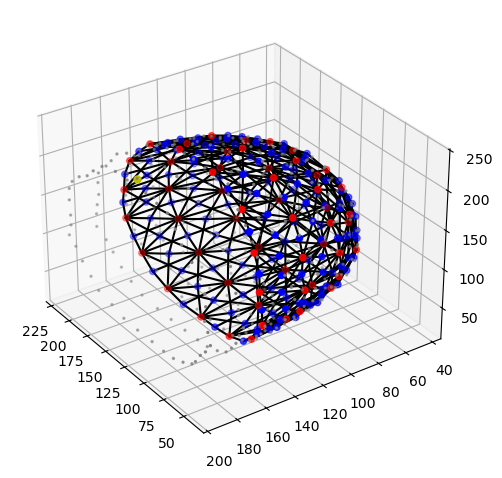

In [4]:
cedalion.plots.plot_montage3D(rec["amp"], geo3d)

In [5]:
amp = amp.pint.dequantify().pint.quantify("V")
amp = repair_amp(amp)

In [6]:
snr_thresh = 10  # the SNR (std/mean) of a channel.
# SNR thresholding using the "snr" function of the quality subpackage
snr, snr_mask = quality.snr(rec["amp"], snr_thresh)
data_masked_snr_2, masked_elements_2 = xrutils.apply_mask(
    rec["amp"], snr_mask, "drop", "channel"
)

In [7]:
od = cedalion.nirs.int2od(amp)

## Construct headmodel

We load headmodel, since we need the geometry for image reconstruction.

In [8]:
if head_model_name == 'icbm':
    SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_icbm152_segmentation()
    parcel_file = cedalion.datasets.get_icbm152_parcel_file()
elif head_model_name == 'colin':
    SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()
    parcel_file = cedalion.datasets.get_colin27_parcel_file()

head = fw.TwoSurfaceHeadModel.from_surfaces(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    brain_surface_file= os.path.join(SEG_DATADIR, "mask_brain.obj"),
    scalp_surface_file= os.path.join(SEG_DATADIR, "mask_scalp.obj"),
    landmarks_ras_file=landmarks_file,
    brain_face_count=None,
    scalp_face_count=None,
    parcel_file=parcel_file,
    fill_holes=True
)

head.landmarks contains the 4 landmarks ['Nz' 'Iz' 'LPA' 'RPA']. 
Since we want to create synthetic HRFs on the brain surface at landmark positions, we need to build the remaining 10-10 landmarks

In [9]:
head.brain.units = cedalion.units.mm
head.scalp.units = cedalion.units.mm
head.landmarks = head.landmarks.pint.dequantify()
head.landmarks.pint.units = cedalion.units.mm

lmbuilder = cd_landmarks.LandmarksBuilder1010(head.scalp, head.landmarks)
all_landmarks = lmbuilder.build()
head.landmarks = all_landmarks

/home/thomas/Dokumente/SHK/cedalion/src/cedalion/geometry/landmarks.py:242: UserWarning: WIP: distance calculation around ears
  warnings.warn("WIP: distance calculation around ears")


In [10]:
center_brain = np.mean(head.brain.mesh.vertices, axis=0)

In [11]:
c3_seed = head.brain.mesh.kdtree.query(head.landmarks.sel(label='C3'))[1]
c4_seed = head.brain.mesh.kdtree.query(head.landmarks.sel(label='C4'))[1]

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [12]:
with open(data_path + 'NN22_Resting_State/NN_22_ICBM_C3_C4_sens_min1_vertices', 'rb') as f:
    c3_c4_sens_vertices = pickle.load(f)
vertices_LH = c3_c4_sens_vertices['LH']
vertices_RH = c3_c4_sens_vertices['RH']
print(len(vertices_LH))
print(len(vertices_RH))

788
1015


In [13]:
head.brain.vertices

Magnitude,[[79.8505638290813 27.233119465566286 154.7249422870077] [78.42663435217018 27.107929757342653 151.04548361602536] [88.85118343681083 27.178165180807227 152.00061713392648] ... [151.86302250636737 121.58621699198721 201.82479114827277] [105.46261160972085 161.73800829587606 213.34504133392807] [119.98238930671796 84.61257854687135 208.70708919524566]]
Units,millimeter


In [14]:
dist_LH = np.linalg.norm(head.brain.vertices[vertices_LH].values - head.brain.vertices[c3_seed].values,axis=1)
vertices_LH = list(head.brain.vertices[vertices_LH].label.values[dist_LH < 10])
dist_RH = np.linalg.norm(head.brain.vertices[vertices_RH].values - head.brain.vertices[c4_seed].values,axis=1)
vertices_RH = list(head.brain.vertices[vertices_RH].label.values[dist_RH < 10])
print(len(vertices_LH))
print(len(vertices_RH))

21
23


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [15]:
len(vertices_LH)

21

In [16]:
#seeds_LH = random.sample(vertices_LH, num_activations)
#seeds_RH = random.sample(vertices_RH, num_activations)

seeds_LH = [3321, 6840, 3123, 2928, 7437, 6713, 3267, 2789, 3318, 3268, 3076, 2880, 3317, 6617, 3119, 3009, 3011, 3160]
seeds_RH = [10441, 10444, 10082, 10524, 10523, 13923, 10699, 10445, 10261, 10525, 10564, 10396, 14536, 10442, 10216, 10796, 14168, 10649]

print(seeds_LH)
print(seeds_RH)

[3321, 6840, 3123, 2928, 7437, 6713, 3267, 2789, 3318, 3268, 3076, 2880, 3317, 6617, 3119, 3009, 3011, 3160]
[10441, 10444, 10082, 10524, 10523, 13923, 10699, 10445, 10261, 10525, 10564, 10396, 14536, 10442, 10216, 10796, 14168, 10649]


In [17]:
parcels = cedalion.io.read_parcellations(parcel_file)

In [18]:
parcel_names = list(set(parcels["Label"].values))
len(parcel_names)

602

In [19]:
# get all parcel names that contain 'PFC'
SomMot_parcels_LH = [p for p in parcel_names if "SomMot" in p and "LH" in p]
print(len(SomMot_parcels_LH))

SomMotA_parcels_LH = [p for p in parcel_names if "SomMotA" in p and "LH" in p]

SomMot_parcels_RH = [p for p in parcel_names if "SomMot" in p and "RH" in p]
print(len(SomMot_parcels_RH))

SomMotA_parcels_RH = [p for p in parcel_names if "SomMotA" in p and "RH" in p]


53
46


In [20]:
len([p for p in parcel_names if "RH" in p])

301

In [21]:
# geo3d_snapped = head.align_and_snap_to_scalp(geo3d)
center_brain = np.mean(head.brain.mesh.vertices, axis=0)

## Build spatial activation pattern on brain surface

In [22]:
import cedalion.dataclasses as cdc
import cedalion.dataclasses.geometry as cdg
import cedalion.imagereco.forward_model as cfm
import cedalion.models.glm as glm
import cedalion.plots
import cedalion.typing as cdt
from cedalion import units
from cedalion.models.glm.basis_functions import TemporalBasisFunction
import scipy.stats as stats


In [23]:
def build_spatial_activation_new(
    head_model: cfm.TwoSurfaceHeadModel,
    seed_vertices: list[int] | int,
    spatial_scale: cdt.QLength = 1 * units.cm,
    intensity_scale: cdt.QConcentration = 1 * units.micromolar,
    hbr_scale: float = None,
    m: float = 10.0,
):
    """Generates a spatial activation at multiple seed vertices.

    Args:
        head_model (cfm.TwoSurfaceHeadModel): Head model with brain and scalp surfaces.
        seed_vertices (list[int]): Indices of the seed vertices.
        spatial_scale (Quantity): Scale of the spatial size.
        intensity_scale (Quantity): Scaling factor for the intensity of the blob.
        hbr_scale (float): Scaling factor for HbR relative to HbO.
        m (float): Geodesic distance parameter.

    Returns:
        xr.DataArray: Spatial image with activation values for each vertex.

    Raises:
        ValueError: If seed vertices belong to different submeshes.
    """

    spatial_scale_unit = (
        (spatial_scale / head_model.brain.units).to_base_units().magnitude
    )

    seed_positions = head_model.brain.mesh.vertices[seed_vertices]
    mesh_split = head_model.brain.mesh.split(only_watertight=False)

    print(f"Number of submeshes: {len(mesh_split)}")
    
    # Determine the submesh for each seed vertex
    submesh_indices = []

    for pos in seed_positions:
        for i, submesh in enumerate(mesh_split):
            if pos in submesh.vertices:
                submesh_indices.append(i)
                break
    # Print the submesh indices for each seed vertex
    
    #print(f"Seed positions: {seed_positions}")
    #print(f"Submesh vertices: {[submesh.vertices for submesh in mesh_split]}")

    print(f"Submesh indices: {submesh_indices}")
    
    # Ensure all seed vertices belong to the same submesh
    if len(set(submesh_indices)) != 1:
        raise ValueError("Seed vertices belong to different submeshes.")
    
    submesh = mesh_split[submesh_indices[0]]
    seed_indices_in_submesh = [
        np.where((submesh.vertices == pos).all(axis=1))[0][0] for pos in seed_positions
    ]
    
    cortex_surface = cdg.PycortexSurface(
        cdg.SimpleMesh(submesh.vertices, submesh.faces),
        crs=head_model.brain.crs,
        units=head_model.brain.units,
    )
    distances_on_submesh = cortex_surface.geodesic_distance(seed_indices_in_submesh, m=m)

    submesh_set = set(map(tuple, submesh.vertices))
    submesh_vertex_indices = [
        i for i, coord in enumerate(map(tuple, head_model.brain.mesh.vertices)) if coord in submesh_set
    ]

    distances_from_seed = np.ones(head_model.brain.mesh.vertices.shape[0]) * np.inf
    distances_from_seed[submesh_vertex_indices] = distances_on_submesh

    norm_pdf = stats.norm(scale=spatial_scale_unit).pdf
    blob_img = norm_pdf(distances_from_seed)
    blob_img = blob_img / np.max(blob_img)
    blob_img = xr.DataArray(blob_img, dims=["vertex"])

    if hbr_scale is not None:
        blob_img = np.stack([blob_img, blob_img * hbr_scale], axis=1)
        blob_img = xr.DataArray(
            blob_img,
            dims=["vertex", "chromo"],
            coords={"chromo": ["HbO", "HbR"]},
        )

    blob_img = blob_img * intensity_scale
    blob_img = blob_img.pint.to(units.molar)

    return blob_img

In [24]:
spatial_imgs = []

for i in range(num_activations):

    if multiple:
        seed_LH = seeds_LH[i]
        seed_RH = seeds_RH[i]
    else:
        seed_LH = c3_seed
        seed_RH = c4_seed

    act_LH = build_spatial_activation_new(
        head,
        [seed_LH],
        spatial_scale=sp_scale * units.cm,
        intensity_scale=1 * units.micromolar,
        hbr_scale=-0.4,
    )

    act_RH = build_spatial_activation_new(
        head,
        [seed_RH],
        spatial_scale=sp_scale * units.cm,
        intensity_scale=1 * units.micromolar,
        hbr_scale=-0.4,
    )

    spatial_imgs.append(xr.concat(
        [act_LH, act_RH], 
        dim="trial_type"
    ).assign_coords(trial_type=["Stim LH", "Stim RH"]))

Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


Number of submeshes: 22
Submesh indices: [0]
Number of submeshes: 22
Submesh indices: [8]


/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


The resulting xarray.DataArray contains an activation value for each vertex and chromophore on the brain surface. We will use this spatial information to create synthetic HRFs.

## Plot spatial patterns @ C3 & C4

There exists a helper function to plot the patterns on the brain surface

In [25]:
plot = True

/home/thomas/anaconda3/envs/cedalion/lib/python3.11/site-packages/xarray/core/variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


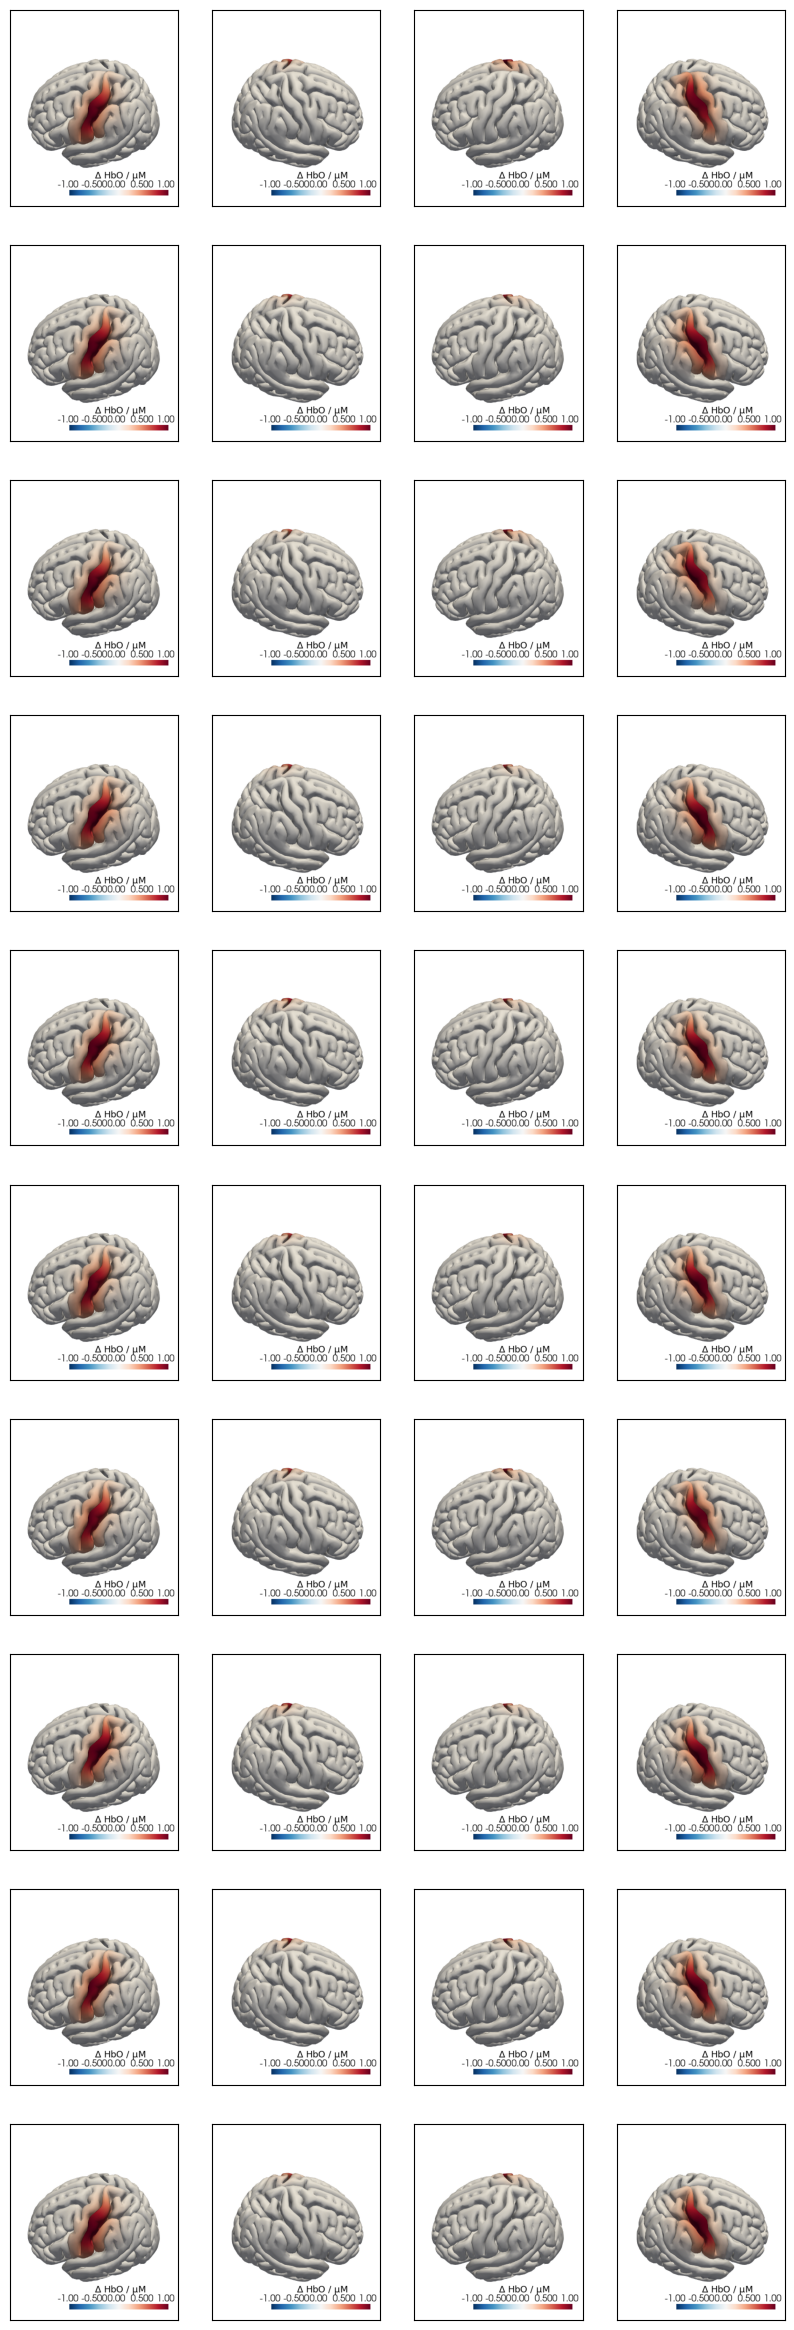

In [26]:

if plot:
    f, ax = plt.subplots(10, 4, figsize=(10, 30))
    range_max = 10 if multiple else 1
    for i in range(range_max):
        cedalion.plots.brain_plot(
            od,
            head.landmarks,
            spatial_imgs[i].sel(trial_type='Stim LH', chromo='HbO').pint.to("uM"),
            head.brain,
            ax[i,0],
            camera_pos="C3",
            cmap="RdBu_r",
            vmin=-1,
            vmax=+1,
            cb_label=r"$\Delta$ HbO / µM",
            title=None,
        )
        cedalion.plots.brain_plot(
            od,
            head.landmarks,
            spatial_imgs[i].sel(trial_type='Stim LH', chromo='HbO').pint.to("uM"),
            head.brain,
            ax[i,1],
            camera_pos="C4",
            cmap="RdBu_r",
            vmin=-1,
            vmax=+1,
            cb_label=r"$\Delta$ HbO / µM",
            title=None,
        )

        cedalion.plots.brain_plot(
            od,
            head.landmarks,
            spatial_imgs[i].sel(trial_type='Stim RH', chromo='HbO').pint.to("uM"),
            head.brain,
            ax[i,2],
            camera_pos="C3",
            cmap="RdBu_r",
            vmin=-1,
            vmax=+1,
            cb_label=r"$\Delta$ HbO / µM",
            title=None,
        )
        cedalion.plots.brain_plot(
            od,
            head.landmarks,
            spatial_imgs[i].sel(trial_type='Stim RH', chromo='HbO').pint.to("uM"),
            head.brain,
            ax[i,3],
            camera_pos="C4",
            cmap="RdBu_r",
            vmin=-1,
            vmax=+1,
            cb_label=r"$\Delta$ HbO / µM",
            title=None,
        )

In [27]:
# Concatenate along a new dimension, e.g., 'stack'
spatial_imgs_stacked = xr.concat(spatial_imgs, dim='stack')

# Compute the mean along the new dimension
mean_spatial_img = spatial_imgs_stacked.mean(dim='stack')

In [28]:
mean_spatial_img

Magnitude,[[[9.857951467911823e-14 -3.9431805871647293e-14] [6.077412059431593e-14 -2.4309648237726376e-14] [3.0682981269087247e-14 -1.2273192507634898e-14] ... [0.0 0.0] [0.0 0.0] [0.0 0.0]] [[0.0 0.0] [0.0 0.0] [0.0 0.0] ... [9.123242910661319e-07 -3.649297164264528e-07] [3.914760385866593e-10 -1.565904154346638e-10] [1.6123956170156476e-07 -6.44958246806259e-08]]]
Units,molar


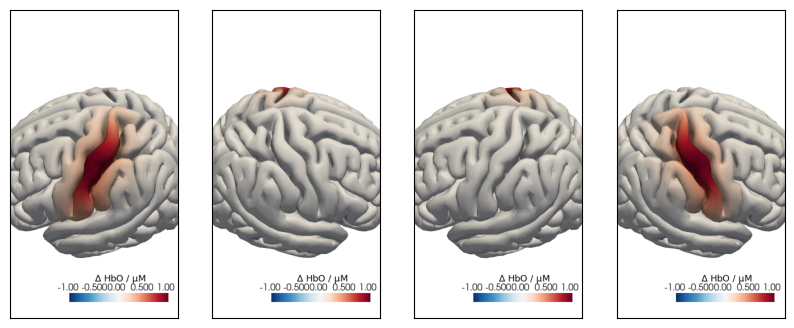

In [29]:
if plot:
    f, ax = plt.subplots(1, 4, figsize=(10, 4))
    cedalion.plots.brain_plot(
        od,
        head.landmarks,
        mean_spatial_img.sel(trial_type='Stim LH', chromo='HbO').pint.to("uM"),
        head.brain,
        ax[0],
        camera_pos="C3",
        cmap="RdBu_r",
        vmin=-1,
        vmax=+1,
        cb_label=r"$\Delta$ HbO / µM",
        title=None,
    )
    cedalion.plots.brain_plot(
        od,
        head.landmarks,
        mean_spatial_img.sel(trial_type='Stim LH', chromo='HbO').pint.to("uM"),
        head.brain,
        ax[1],
        camera_pos="C4",
        cmap="RdBu_r",
        vmin=-1,
        vmax=+1,
        cb_label=r"$\Delta$ HbO / µM",
        title=None,
    )

    cedalion.plots.brain_plot(
        od,
        head.landmarks,
        mean_spatial_img.sel(trial_type='Stim RH', chromo='HbO').pint.to("uM"),
        head.brain,
        ax[2],
        camera_pos="C3",
        cmap="RdBu_r",
        vmin=-1,
        vmax=+1,
        cb_label=r"$\Delta$ HbO / µM",
        title=None,
    )
    cedalion.plots.brain_plot(
        od,
        head.landmarks,
        mean_spatial_img.sel(trial_type='Stim RH', chromo='HbO').pint.to("uM"),
        head.brain,
        ax[3],
        camera_pos="C4",
        cmap="RdBu_r",
        vmin=-1,
        vmax=+1,
        cb_label=r"$\Delta$ HbO / µM",
        title=None,
    )

In [30]:
print(mean_spatial_img.sel(trial_type="Stim LH", chromo='HbO').values.max())
print(mean_spatial_img.sel(trial_type="Stim LH", chromo='HbR').values.min())
print(mean_spatial_img.sel(trial_type="Stim RH", chromo='HbO').values.max())
print(mean_spatial_img.sel(trial_type="Stim RH", chromo='HbR').values.min())

9.777266976031598e-07
-3.910906790412638e-07
9.724201997458736e-07
-3.889680798983494e-07


## Image Reconstruction

We load the precomputed Adot matrix to be able to map from image to channel space. (See image_reconstruction example notebook).

In [31]:
if head_model_name == 'icbm':
    Adot = cedalion.datasets.get_precomputed_sensitivity('nn22_resting', head_model='icbm152')
elif head_model_name == 'colin':
    Adot = cedalion.datasets.get_precomputed_sensitivity('nn22_resting', head_model='colin27')

In [32]:
od

Magnitude,[[[-0.022896129953454525 -0.02387097113263633 -0.025390777477198187 ... -0.001912564541603616 -0.0020605178725347445 -0.003371267084858785] [-0.04103965662341875 -0.04237938939847012 -0.04450333816938149 ... 0.004338035362661875 0.004164698433758317 0.002298416025786465]] [[-0.03804269562780125 -0.03854637174308498 -0.03950464904219351 ... 0.019992076536129732 0.019992076536129732 0.019646153926384472] [-0.04544057879893568 -0.046031262025763034 -0.04751574870909784 ... 0.02607803708828565 0.026178869995811947 0.026178869995811947]] [[-0.015610309930013336 -0.016945491599523917 -0.01927521668635137 ... -0.0013195634675905415 -0.0014371616574729504 -0.0032042102231390813] [-0.025388385435625167 -0.02726588292788964 -0.030936908698066035 ... 0.0076519886581822745 0.007378176131269285 0.004292127361486108]] ... [[0.017932265136728947 0.01692472372849332 0.014671431972237239 ... 0.0022050632517635316 0.001424080927615169 -0.0012994234610967399] [0.02031923996035514 0.01866542325413216 0.014314298401890782 ... 0.010973300692388034 0.010080145301944517 0.0058408535644761065]] [[0.04515852982432387 0.039159236116878396 0.03741676708808542 ... -0.04621126497703754 -0.05111565193283947 -0.05636768007183168] [0.0229965583035885 0.01576627347594597 0.009704725007747475 ... -0.026085186016649782 -0.031513039604212055 -0.039153122915119284]] [[-0.006453715959369515 -0.007083311757967186 -0.008981758926629854 ... -0.003621668846570805 -0.003968614770279046 -0.005240687344056346] [-0.027758638419581202 -0.029267123226348692 -0.03229493510249789 ... -0.009175764589454303 -0.009175764589454303 -0.011441511519204153]]]
Units,dimensionless


In [33]:
(Adot.is_brain).values

array([ True,  True,  True, ..., False, False, False])

In [34]:
import cedalion.vis.plot_sensitivity_matrix

In [35]:
plotter = cedalion.vis.plot_sensitivity_matrix.Main(
    sensitivity=Adot,
    brain_surface=head.brain,
    head_surface=head.scalp,
    labeled_points=None,
)
plotter.plot(high_th=0, low_th=-3)
plotter.plt.show()

Widget(value='<iframe src="http://localhost:32947/index.html?ui=P_0x7daf514d1410_44&reconnect=auto" class="pyv…

In [36]:
# we only map from brain vertices, not scalp
Adot_brain = Adot[:, (Adot.is_brain).values,:]
#Adot_brain = Adot

In [37]:
Adot_stacked = fw.ForwardModel.compute_stacked_sensitivity(Adot_brain)

In [38]:
Adot_inverted = pseudo_inverse_stacked(Adot_stacked, alpha = 0.01, alpha_spatial = 1e-4)
Adot_inverted = Adot_inverted.pint.quantify()
Adot_inverted

Magnitude,[[8.489564047979406e-12 -1.862732895835477e-12 -4.512582258077319e-12 ... 1.2323895004882741e-12 -1.9503513737792694e-08 -1.5709643469155483e-13] [6.91069678447977e-12 -3.3133391167769862e-12 2.5568672241981846e-13 ... -3.1808676799099707e-12 1.8836918515318823e-08 -1.443710717255571e-13] [1.299589438070412e-12 7.539785456975255e-12 -6.669636401630568e-11 ... -1.0319640096253022e-11 -2.4387190938303144e-07 -1.8078644228452737e-12] ... [-7.914386432681221e-06 2.211070447276067e-06 3.2921402847675883e-06 ... 2.2283832566085012e-08 -7.993965386541625e-08 4.092946505095119e-08] [-3.541450402377945e-07 -1.3033189458740257e-07 -2.323895502135381e-07 ... 2.4681093420295754e-07 6.871634695406128e-09 1.306368231769664e-07] [3.0404850395898414e-08 1.7708319375502395e-07 -7.094203750644538e-08 ... -7.584521056667451e-08 3.89523897181851e-05 -1.4009723475298973e-09]]
Units,molar


In [39]:
spatial_imgs_stacked = [fw.stack_flat_vertex(s) for s in spatial_imgs]

### We can now map our spatial patterns to channel space

In [40]:
spatial_chan_stacked = [Adot_stacked @ s for s in spatial_imgs_stacked]

In [41]:
spatial_chan = [fw.unstack_flat_channel(s) for s in spatial_chan_stacked]

In [42]:
spatial_chan = [s.pint.dequantify() for s in spatial_chan]

In [43]:
#for i in range(len(spatial_chan)):
#    spatial_chan[i][:,:,short_chan_mask] = 0

In [44]:
path = data_path + "/NN22_Resting_State/NN22_syn_act/"

In [45]:
import pickle

In [46]:
print(spatial_chan[0].sel(trial_type="Stim LH", wavelength=850).values.min())
print(spatial_chan[0].sel(trial_type="Stim LH", wavelength=850).values.max())
print(spatial_chan[0].sel(trial_type="Stim RH", wavelength=850).values.min())
print(spatial_chan[0].sel(trial_type="Stim RH", wavelength=850).values.max())

8.354738431051148e-20
0.004594159056446407
3.2409648967691205e-20
0.010183710130829164


In [47]:
# Concatenate along a new dimension, e.g., 'stack'
spatial_chan_stacked = xr.concat(spatial_chan, dim='stack')

# Compute the mean along the new dimension
mean_spatial_chan = spatial_chan_stacked.mean(dim='stack')

In [48]:
ts_long, ts_short = cedalion.nirs.split_long_short_channels(
    od, rec.geo3d, distance_threshold=2.6 * units.cm
)
short_chan_mask = np.isin(od.channel.values, ts_short.channel.values)

In [49]:
print(mean_spatial_chan[:,:,short_chan_mask].values.max())
print(mean_spatial_chan.values.max())
print(mean_spatial_chan[:,:,short_chan_mask].values.max() / mean_spatial_chan.values.max())

0.006740503271700802
0.009636082272484347
0.6995066128636306


Show the spatial activation in channel space with a scalp plot.

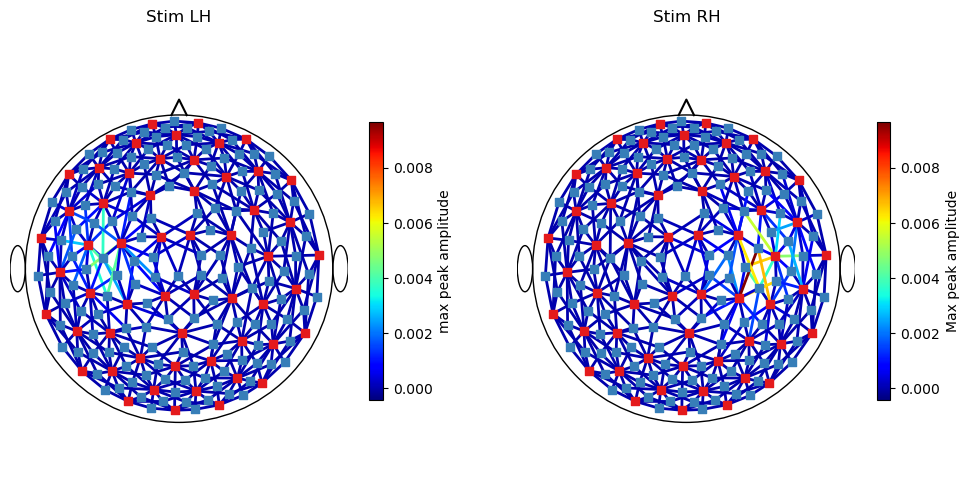

In [50]:
fig, ax = plt.subplots(1, 2)
# adjust plot size
fig.set_size_inches(12, 6)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    mean_spatial_chan.sel(trial_type="Stim LH", wavelength=850).values,
    ax[0],
    cmap="jet",
    title="Stim LH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="max peak amplitude",
)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    mean_spatial_chan.sel(trial_type="Stim RH", wavelength=850).values,
    ax[1],
    cmap="jet",
    title="Stim RH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="Max peak amplitude",
)
plt.show()

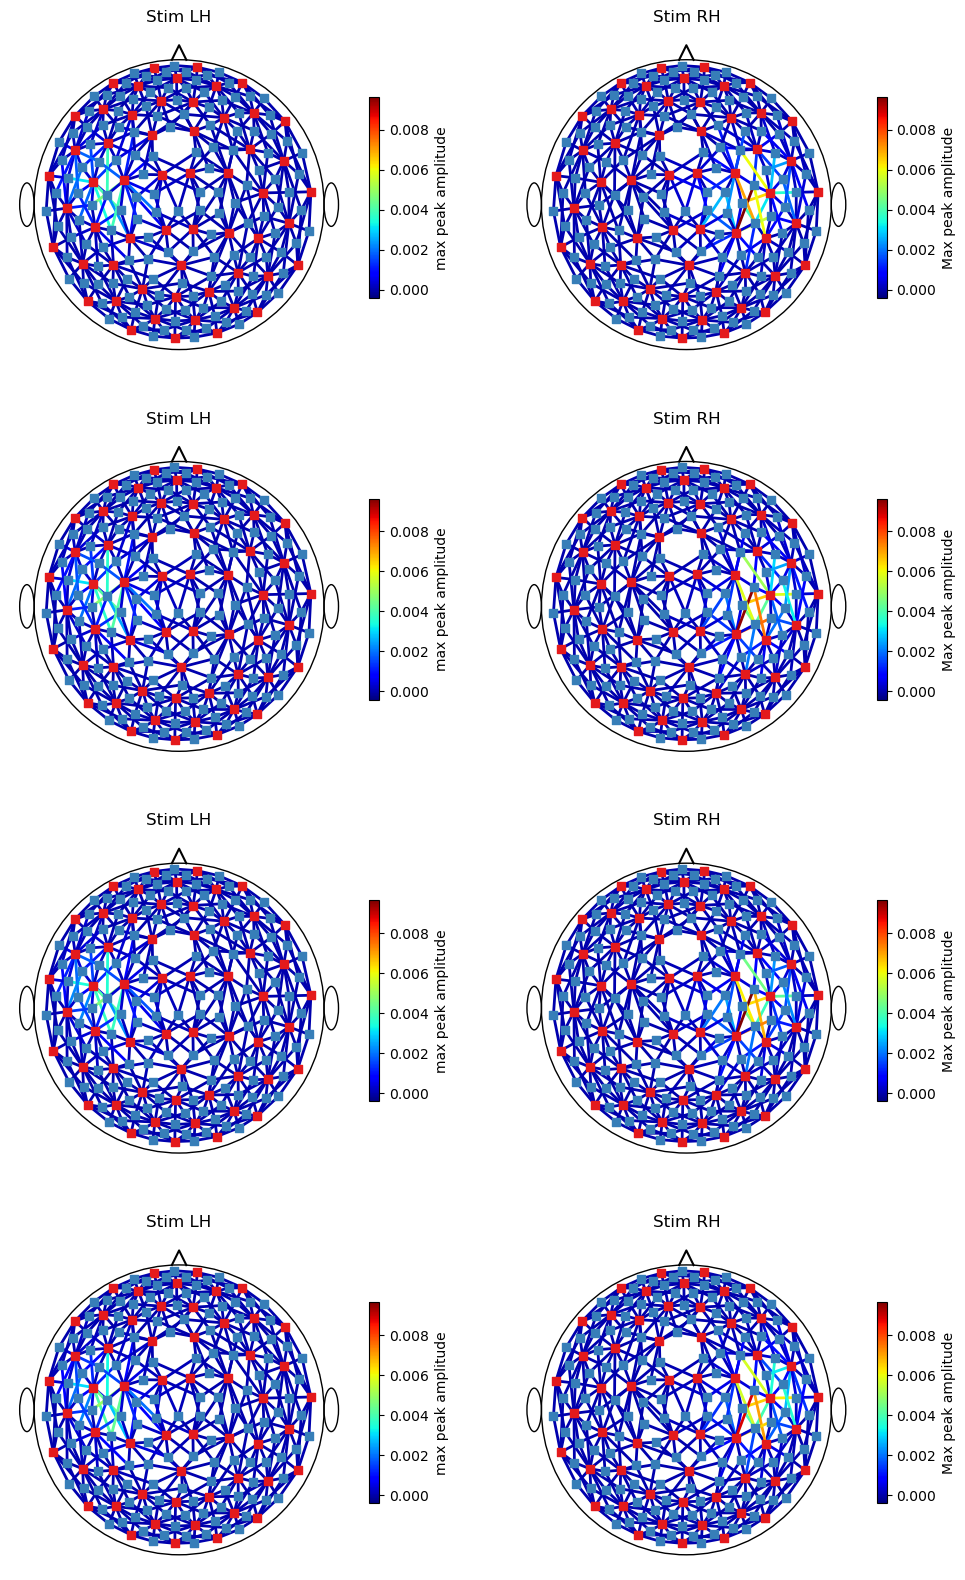

In [51]:
fig, ax = plt.subplots(4, 2)
# adjust plot size
fig.set_size_inches(12, 20)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[0].sel(trial_type="Stim LH", wavelength=850).values,
    ax[0, 0],
    cmap="jet",
    title="Stim LH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="max peak amplitude",
)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[0].sel(trial_type="Stim RH", wavelength=850).values,
    ax[0, 1],
    cmap="jet",
    title="Stim RH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="Max peak amplitude",
)

cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[1].sel(trial_type="Stim LH", wavelength=850).values,
    ax[1, 0],
    cmap="jet",
    title="Stim LH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="max peak amplitude",
)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[1].sel(trial_type="Stim RH", wavelength=850).values,
    ax[1, 1],
    cmap="jet",
    title="Stim RH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="Max peak amplitude",
)

cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[2].sel(trial_type="Stim LH", wavelength=850).values,
    ax[2, 0],
    cmap="jet",
    title="Stim LH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="max peak amplitude",
)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[2].sel(trial_type="Stim RH", wavelength=850).values,
    ax[2, 1],
    cmap="jet",
    title="Stim RH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="Max peak amplitude",
)

cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[3].sel(trial_type="Stim LH", wavelength=850).values,
    ax[3, 0],
    cmap="jet",
    title="Stim LH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="max peak amplitude",
)
cedalion.plots.scalp_plot(
    mean_spatial_chan,
    rec.geo3d,
    spatial_chan[3].sel(trial_type="Stim RH", wavelength=850).values,
    ax[3, 1],
    cmap="jet",
    title="Stim RH",
    vmin=mean_spatial_chan.values.min(),
    vmax=mean_spatial_chan.values.max(),
    cb_label="Max peak amplitude",
)

plt.show()

In [52]:
spatial_chan[0]

<xarray.DataArray (trial_type: 2, wavelength: 2, channel: 567)> Size: 18kB
-2.396e-11 -1.988e-09 -9.898e-10 -4.382e-12 ... 4.737e-05 2.631e-06 2.396e-06
Coordinates:
  * wavelength  (wavelength) float64 16B 760.0 850.0
  * channel     (channel) object 5kB 'S10D112' 'S10D133' ... 'S9D94' 'S9D96'
  * trial_type  (trial_type) <U7 56B 'Stim LH' 'Stim RH'
    source      (channel) object 5kB 'S10' 'S10' 'S10' 'S10' ... 'S9' 'S9' 'S9'
    detector    (channel) object 5kB 'D112' 'D133' 'D135' ... 'D92' 'D94' 'D96'
Attributes:
    units:    molar

In [53]:
# FIXME: Our spatial_chan is in od. We need to map it to channel space again so we can
# rescale the amplitude.
# We want a max amplitude of 1 micromolar in our synthetic activation, but it got
# scaled by the forward model.

In [54]:
dpf = xr.DataArray(
    [6, 6],
    dims="wavelength",
    coords={"wavelength": rec["amp"].wavelength},
)

In [55]:
# add time axis with one time point so we can convert to conc
spatial_chan_w_time = spatial_chan[0].expand_dims("time")
spatial_chan_w_time = spatial_chan_w_time.assign_coords(time=[0])
spatial_chan_w_time.time.attrs["units"] = "second"
spatial_chan_conc = cedalion.nirs.od2conc(
    spatial_chan_w_time, geo3d, dpf, spectrum="prahl"
)

In [56]:
# rescale so that synthetic hrfs add 1 micromolar at peak.
rescale_factor = (1* units.micromolar / spatial_chan_conc.max())

In [57]:
#rescale_factor = 7

In [58]:
rescale_factor

<xarray.DataArray 'concentration' ()> Size: 8B
[] 4.463

In [59]:
spatial_chan[0].max()

<xarray.DataArray ()> Size: 8B
0.01018

In [60]:
spatial_chan = [s * rescale_factor for s in spatial_chan]

In [61]:
spatial_chan[0].max()

<xarray.DataArray ()> Size: 8B
[] 0.04545

In [62]:
if save:

    if multiple:

        for i in range(num_activations):
            filename = f'NN22_Resting_State/NN22_syn_act/Finger_Tapping/multiple/syn_hrf_Finger_Tapping_chan_sp_{sp_scale}_int_1_num{i}.nc'
            dirname =  data_path

            spatial_chan[i].to_netcdf(os.path.join(dirname, filename))
            print(f"Saved {dirname}{filename}.")

    else:
        spatial_chan = spatial_chan[0]
        filename = f'NN22_Resting_State/NN22_syn_act/Finger_Tapping/syn_hrf_Finger_Tapping_chan_sp_{sp_scale}_int_1.nc'
        dirname =  data_path

        spatial_chan.to_netcdf(os.path.join(dirname, filename))
        print(f"Saved {dirname}{filename}.")

Saved /home/thomas/Dokumente/Master/Master_Thesis/HD-DOT Classification/data/NN22_Resting_State/NN22_syn_act/Finger_Tapping/multiple/syn_hrf_Finger_Tapping_chan_sp_3_int_1_num0.nc.
Saved /home/thomas/Dokumente/Master/Master_Thesis/HD-DOT Classification/data/NN22_Resting_State/NN22_syn_act/Finger_Tapping/multiple/syn_hrf_Finger_Tapping_chan_sp_3_int_1_num1.nc.
Saved /home/thomas/Dokumente/Master/Master_Thesis/HD-DOT Classification/data/NN22_Resting_State/NN22_syn_act/Finger_Tapping/multiple/syn_hrf_Finger_Tapping_chan_sp_3_int_1_num2.nc.
Saved /home/thomas/Dokumente/Master/Master_Thesis/HD-DOT Classification/data/NN22_Resting_State/NN22_syn_act/Finger_Tapping/multiple/syn_hrf_Finger_Tapping_chan_sp_3_int_1_num3.nc.
Saved /home/thomas/Dokumente/Master/Master_Thesis/HD-DOT Classification/data/NN22_Resting_State/NN22_syn_act/Finger_Tapping/multiple/syn_hrf_Finger_Tapping_chan_sp_3_int_1_num4.nc.
Saved /home/thomas/Dokumente/Master/Master_Thesis/HD-DOT Classification/data/NN22_Resting_State